In [1]:
%matplotlib widget
import os
import h5py
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time
from IPython.display import Image, display
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from sklearn.neighbors import KernelDensity
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5
from lakeanalysis.nsidc import download_is2, read_atl03

In [2]:
out_path_csv = 'data/lakestats_methods_paper.csv'
df_stats = pd.read_csv(out_path_csv)

In [3]:
df_stats = df_stats[df_stats.ice_sheet == 'AIS']

In [4]:
from sklearn.neighbors import KDTree

def get_signal(df, n_iter=100, h_thresh=[200,3], xatc_win=[500,7]):
    number_iterations = n_iter
    elevation_threshold_start = h_thresh[0]
    elevation_threshold_end = h_thresh[1]
    xatc_window_width_start = xatc_win[0]
    xatc_window_width_end = xatc_win[1]
    
    df.xatc -= df.xatc.min()
    df['is_signal'] = True
    df['rmean'] = np.nan
    
    def get_params(start,end,number):
        return [start * ((end / start)**(1/(number-1))) ** it for it in range(number)]
    
    h_diff_thresholds = get_params(start=elevation_threshold_start, end=elevation_threshold_end, number=number_iterations)
    window_sizes = np.int32(np.round(get_params(start=xatc_window_width_start, end=xatc_window_width_end, number=number_iterations)))

    for i in range(number_iterations):
        rmean = df.h[df.is_signal].rolling(3*window_sizes[i],center=True,min_periods=5,win_type='gaussian').mean(
            std=int(np.ceil(window_sizes[i]/2)))
        df['rmean'] = np.interp(df.xatc, df.xatc[df.is_signal], rmean)
        df['is_signal'] = np.abs(df.rmean-df.h) < h_diff_thresholds[i]
        
    rmean = df.h[df.is_signal].rolling(5*window_sizes[i],center=True,min_periods=5,win_type='gaussian').mean(std=window_sizes[-1])
    df['rmean'] = np.interp(df.xatc, df.xatc[df.is_signal], rmean)
    
    return df
    

# function for robust (iterative) nonparametric regression (to fit surface and bed of lake)
def robust_npreg(df_fit, n_iter=10, poly_degree=1, len_xatc_min=5, n_points=[100,30], 
    resolutions=[5,1], stds=[20,6], full=False, init=None):
    
    h_list = []
    x_list = []
    n_phots = np.linspace(n_points[0], n_points[1], n_iter)
    resols = np.linspace(resolutions[0], resolutions[1], n_iter)
    n_stds = np.hstack((np.linspace(stds[0], stds[1], n_iter-1), stds[1]))
    minx = df_fit.xatc.min()
    maxx = df_fit.xatc.max()

    # take into account initial guess, if specified (needs to be dataframe with columns 'xatc' and 'h')
    if (init is not None) and (len(init) > 0): 
        range_vweight = 10.0
        df_fit['heights_fit'] = np.interp(df_fit.xatc, init.xatc, init.h, left=np.nan, right=np.nan)
        vert_weight = (1.0 - np.clip((np.abs(df_fit.h-df_fit.heights_fit)/range_vweight),0,1)**3 )**3
        vert_weight[np.isnan(vert_weight)] = 0.01
        df_fit['vert_weight'] = vert_weight
    else: 
        df_fit['vert_weight'] = 1.0
    
    for it in range(n_iter):
        
        n_phot = n_phots[it]
        res = resols[it]
        n_std = n_stds[it]
        evaldf = pd.DataFrame(np.arange(minx,maxx+res,step=res),columns=['xatc'])
        h_arr = np.full_like(evaldf.xatc,fill_value=np.nan)
        stdev_arr = np.full_like(evaldf.xatc,fill_value=np.nan)
        df_fit_nnz = df_fit[df_fit.vert_weight > 1e-3].copy()

        # for every point at which to evaluate local fit
        for i,x in enumerate(evaldf.xatc):
            
            # look for the closest n_phot photons around the center point for local polynomial fit
            idx_closest_photon = np.argmin(np.abs(np.array(df_fit_nnz.xatc - x)))
            n_phot_each_side = int(np.ceil(n_phot / 2))
            idx_start = np.clip(idx_closest_photon - n_phot_each_side, 0, None)
            idx_end = np.clip(idx_closest_photon + n_phot_each_side +1, None, len(df_fit_nnz)-1)
            xatc_start = df_fit_nnz.iloc[idx_start].xatc
            xatc_end = df_fit_nnz.iloc[idx_end].xatc
            len_xatc = xatc_end - xatc_start

            # if the fit for n_phot does not span at least len_xatc_min, then make the segment longer
            if len_xatc < len_xatc_min: 
                xstart = x - len_xatc_min/2
                xend = x + len_xatc_min/2
                idx_start = np.min((int(np.clip(np.argmin(np.abs(np.array(df_fit_nnz.xatc - xstart))), 0, None)), idx_start))
                idx_end = np.max((int(np.clip(np.argmin(np.abs(np.array(df_fit_nnz.xatc - xend))), None, len(df_fit_nnz)-1)), idx_end))

            # make a data frame with the data for the fit
            dfi = df_fit_nnz.iloc[idx_start:idx_end].copy()

            # tricube weights for xatc distance from evaluation point
            maxdist = np.nanmax(np.abs(dfi.xatc - x))
            dfi['weights'] = (1.0-(np.abs(dfi.xatc-x)/(1.00001*maxdist))**3)**3

            # also weight by the SNR values and the vertical distance from previous fit 
            dfi.weights *= dfi.density
            if (init is not None) | (it > 0):  # vertical weights are only available after first iteration or with initial guess
                dfi.weights *= dfi.vert_weight

            # do the polynomial fit
            try: 
                reg_model = np.poly1d(np.polyfit(dfi.xatc, dfi.h, poly_degree, w=dfi.weights))
                h_arr[i] = reg_model(x)
                stdev_arr[i] = np.average(np.abs(dfi.h - reg_model(dfi.xatc)), weights=dfi.weights) # use weighted mean absolute error
            except:  # if polynomial fit does not converge, use a weighted average
                h_arr[i] = np.average(dfi.h,weights=dfi.weights)
                stdev_arr[i] = np.average(np.abs(dfi.h - h_arr[i]), weights=dfi.weights) # use weighted mean absolute error
            
        evaldf['h_fit'] = h_arr
        evaldf['stdev'] = stdev_arr
        
        # interpolate the fit and residual MAE to the photon-level data
        df_fit['heights_fit'] = np.interp(df_fit.xatc, evaldf.xatc, evaldf.h_fit, left=-9999, right=-9999)
        df_fit['std_fit'] = np.interp(df_fit.xatc, evaldf.xatc, evaldf.stdev)

        # compute tricube weights for the vertical distance for the next iteration
        width_vweight = np.clip(n_std*df_fit.std_fit,0.0, 10.0)
        df_fit['vert_weight'] = (1.0 - np.clip((np.abs(df_fit.h-df_fit.heights_fit)/width_vweight),0,1)**3 )**3
        df_fit.loc[df_fit.heights_fit == -9999, 'vert_weight'] = 0.0 # give small non-zero weight for leading and trailing photons
        
        if full:
            h_list.append(h_arr)
            x_list.append(evaldf.xatc)

        # print('iteration %i / %i' % (it+1, n_iter), end='\r')

    if full:
        return evaldf, df_fit, x_list, h_list
    else:
        return evaldf, df_fit


def get_density(df, segment_length=140, signal_width=0.35, aspect=30, K_phot=10, h_signal=None, frac_noise=0.05):
    n_segs = int(np.ceil((df.xatc.max()-df.xatc.min())/segment_length))
    len_seg = (df.xatc.max()-df.xatc.min())/n_segs
    edges = np.arange(df.xatc.min(), df.xatc.max()+len_seg/2, len_seg)
    df['density'] = 0.0
    for i in range(len(edges)-1):
        selector_segment = (df.xatc>=edges[i]) & (df.xatc<edges[i+1])
        dfseg = df[selector_segment].copy()
        xmin = edges[i]
        xmax = edges[i+1]
        if h_signal:
            dfseg_nosurface = dfseg[np.abs(dfseg.h-h_signal) > signal_width]
        else:
            dfseg_nosurface = dfseg[np.abs(dfseg.h-dfseg.rmean) > signal_width]
        nphot_bckgrd = len(dfseg_nosurface.h)
    
        # radius of a circle in which we expect to find one noise photon
        telem_h = dfseg_nosurface.h.max()-dfseg_nosurface.h.min()
        h_noise = telem_h-signal_width*2
        wid_noise = (xmax-xmin)/aspect
        area = h_noise*wid_noise/nphot_bckgrd
        # wid = np.sqrt(K_phot*area/(2*np.pi))
        # wid = np.sqrt(area / 3)
        fac=3
       # fac = np.pi
        wid = np.sqrt(fac*frac_noise*(K_phot+1)*area/np.pi)
    
        # buffer segment for density calculation
        selector_buffer = (df.xatc >= (dfseg.xatc.min()-aspect*wid)) & (df.xatc <= (dfseg.xatc.max()+aspect*wid))
        dfseg_buffer = df[selector_buffer].copy()
    
        # normalize xatc to be regularly spaced and scaled by the aspect parameter
        xmin_buff = dfseg_buffer.xatc.min()
        xmax_buff = dfseg_buffer.xatc.max()
        nphot_buff = len(dfseg_buffer.xatc)
        xnorm = np.linspace(xmin_buff, xmax_buff, nphot_buff) / aspect
    
        # KD tree query distances
        Xn = np.array(np.transpose(np.vstack((xnorm, dfseg_buffer['h']))))
        kdt = KDTree(Xn)
        idx, dist = kdt.query_radius(Xn, r=wid, count_only=False, return_distance=True,sort_results=True)
        density = (np.array([np.sum(1-np.abs(x/wid)) if (len(x)<(K_phot+1)) 
                   else np.sum(1-np.abs(x[:K_phot+1]/wid))
                   for x in dist]) - 1) / K_phot

        # density[density>frac_noise] = density[density>frac_noise] / np.percentile(density[np.abs(dfseg_buffer.h-h_signal) > signal_width],95)
        # density = np.clip(density, 0, 1)
        # density /= np.max(density)
        # density[density<(2*frac_noise)] = 0.0
    
        # get densities only for segment
        selector_segment_only = (np.array(dfseg_buffer.xatc)>=edges[i]) & (np.array(dfseg_buffer.xatc)<edges[i+1])
        densities = np.array(density[selector_segment_only])
        df.loc[selector_segment, 'density'] = densities
        
    return df

0 data/lakes/lake_09915520_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0062.h5 

-72.8859295027974 67.30819767218487
2019-01-02T18:49:15Z
ATL03_20190102184312_00810210_006_02.h5
81
gt2l
  reading in data/atl03_raw/ATL03_20190102184312_00810210_006_02_gt2l_0062.h5
  reading in beam: gt2l  --> done.


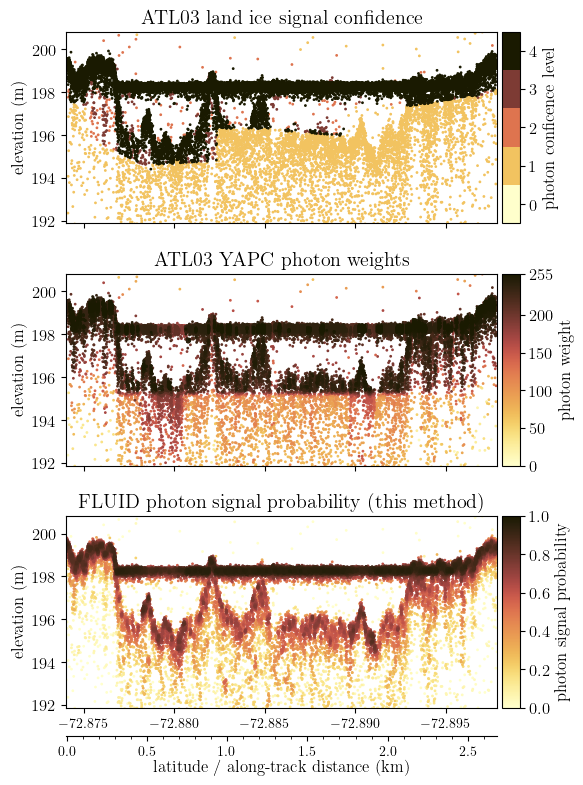

_____________________________________________________________



In [10]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
cmap_fig = cmc.lajolla

files = [
    #    'data/lakes/lake_04476359_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190716051841_02770403_006_02_gt1l_0000.h5',
    #'data/lakes/lake_06815846_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0007.h5',
    #    'data/lakes/lake_07867606_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt1l_0001.h5',
    #    'data/lakes/lake_07947542_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190712181153_02240405_006_02_gt3l_0001.h5',
    #'data/lakes/lake_08793839_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200713115804_02770803_006_01_gt2l_0019.h5',
    #    'data/lakes/lake_09008845_GrIS_2020_simplified_GRE_2000_CW_ATL03_20200713115804_02770803_006_01_gt1l_0005.h5',
    #'data/lakes/lake_08858209_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190613065109_11610303_006_02_gt1l_0001.h5',
    #    'data/lakes/lake_09757904_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0054.h5',
    #    'data/lakes/lake_09778059_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190123173555_04010210_006_02_gt3l_0022.h5',
    'data/lakes/lake_09915520_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0062.h5',
    #    'data/lakes/lake_09981703_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190124062339_04090212_006_02_gt2l_0001.h5',
    # 'data/lakes/lake_09909316_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190115175225_02790210_006_02_gt2r_0020.h5',
    #'data/lakes/lake_09879690_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190617064249_12220303_006_02_gt2l_0019.h5',
    #'data/lakes/lake_09943900_GrIS_2019_simplified_GRE_2000_CW_ATL03_20190822162310_08490405_006_02_gt2l_0001.h5',
]

start = 0
# end = 1
# files = np.array(df_stats.file_name)[start:end]

# files = np.array(df_stats.file_name)[[1]]

for i, fn in enumerate(files):

    print(start+i, fn[fn.find('data/lakes/lake_'):], '\n')
    
    # read in the melt lake data
    lk = dictobj(read_melt_lake_h5(fn))
    print(lk.lat, lk.lon)
    print(lk.time_utc)
    print(lk.granule_id)
    print(lk.rgt)
    print(lk.gtx)
    
    df = lk.photon_data
    df_mframe = lk.mframe_data
    xatcmin = df.xatc.min()
    df.xatc -= xatcmin
    surf_elev = lk.surface_elevation
    latmin = df.lat.min()
    latmax = df.lat.max()
    lonmin = df.lon.min()
    lonmax = df.lon.max()
    thisdate = lk.time_utc[:10]
    rgt = lk.rgt
    gtx = lk.gtx

    df = df.sort_values(by='xatc').reset_index(drop=True)
    # df2 = get_signal(df, n_iter=100, h_thresh=[200,3], xatc_win=[50,10])
    df.is_afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    df2 = df[~df.is_afterpulse].copy()
    df2 = get_density(df2[~df2.is_afterpulse], segment_length=100, signal_width=0.3, aspect=30, K_phot=15, h_signal=surf_elev, frac_noise=0.05)
    #df['density'] = df2.density
    df['density'] = 0
    df.loc[~df.is_afterpulse,'density'] = np.array(df2.density)
    # df = df2.copy()

    # download ATL03 data from NSIDC
    atl03_dir = 'data/atl03_raw'
    fn_atl03 = atl03_dir + '/' + fn[fn.find('ATL03_'):]
    if not os.path.isfile(fn_atl03):
        bbox = [lonmin, latmin, lonmax, latmax]
        granule_list = download_is2(start_date=thisdate, end_date=thisdate, rgt=rgt, boundbox=bbox, output_dir='data/atl03_raw')
        for gran in granule_list:
            if lk.granule_id[:30] in gran:
                thisfile = atl03_dir + '/processed_' + gran
                break
        os.rename(thisfile, fn_atl03)

    # read in ATL03 data from NSIDC
    beams_available, ancillary, dfs = read_atl03(fn_atl03, geoid_h=True, gtxs_to_read=gtx)
    df03 = dfs[gtx]

    #ylms = np.array((-2*lk.max_depth, 0.7*lk.max_depth)) + surf_elev
    ylms = np.array((-2.5*lk.max_depth, 1*lk.max_depth)) + surf_elev
    xlms = (df.lat.min(), df.lat.max())

    fig, axs = plt.subplots(figsize=[6, 8], dpi=100, nrows=3, ncols=1, sharex=True)
    ax = axs[0]
    df_conf = df03.sort_values(by='conf')
    n_bins = 5
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(df_conf.lat, df_conf.h, s=1, alpha=1, c=df_conf.conf, cmap=thecmap, vmin=-0.5, vmax=4.5)
    ax.set_title('ATL03 land ice signal confidence')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('photon conficence level')

    ax = axs[1]
    df_yapc = df03.sort_values(by='weight_ph')
    n_bins = 255
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(df_yapc.lat, df_yapc.h, s=1, alpha=1, c=df_yapc.weight_ph, cmap=thecmap, vmin=0, vmax=255)
    ax.set_title('ATL03 YAPC photon weights')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical', ticks=[0, 50, 100, 150, 200, 255])
    cbar.set_label('photon weight')

    # ax = axs[2]
    # df_snr = df.sort_values(by='snr')
    # n_bins = 1000
    # colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    # thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    # scatt = ax.scatter(df_snr.lat, df_snr.h, s=1, alpha=1, c=df_snr.snr/df_snr.snr.max(), cmap=thecmap, vmin=0, vmax=1)
    # ax.set_title('FLUID photon signal probability (this method)')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='4%', pad=0.05)
    # cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    # cbar.set_label('photon signal probability')

    ax = axs[2]
    dfp = df.sort_values(by='density')
    dfp = dfp[~dfp.is_afterpulse]
    n_bins = 1000
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(dfp.lat, dfp.h, s=1, alpha=1, c=dfp.density, cmap=thecmap, vmin=0, vmax=1)
    ax.set_title('FLUID photon signal probability (this method)')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('photon signal probability')
    
    for ax in axs.flatten():
        ax.set_xlim(xlms)
        ax.set_ylim(ylms)
        ax.set_ylabel('elevation (m)')

    axs[2].ticklabel_format(useOffset=False, style='plain')
    axs[2].tick_params(axis='x', labelsize=10)

    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

    # flip x-axis if track is descending, to make along-track distance go from left to right
    if gt.lat.iloc[0] > gt.lat.iloc[-1]:
        for axx in axs.flatten():
            axx.set_xlim(np.flip(np.array(xlms)))

    # add along-track distance
    lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
    _lat = np.array(lx.lat)
    _xatc = np.array(lx.x10) / 1e3
    def lat2xatc(l):
        return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
    def xatc2lat(x):
        return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])
    secax = ax.secondary_xaxis(-0.15, functions=(lat2xatc, xatc2lat))
    secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
    secax.tick_params(axis='both', which='major', labelsize=10)
    secax.ticklabel_format(useOffset=False, style='plain')
    
    fig.tight_layout()
    #plt.savefig('plots/density_comparison_%i.jpg' % (i+1), dpi=600)
    
    plt.close(fig)
    display(fig)

    print('_____________________________________________________________\n')


In [ ]:
# make it landscape

0 data/lakes/lake_09915520_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0062.h5 

-72.8859295027974 67.30819767218487
2019-01-02T18:49:15Z
ATL03_20190102184312_00810210_006_02.h5
81
gt2l
  reading in data/atl03_raw/ATL03_20190102184312_00810210_006_02_gt2l_0062.h5
  reading in beam: gt2l  --> done.


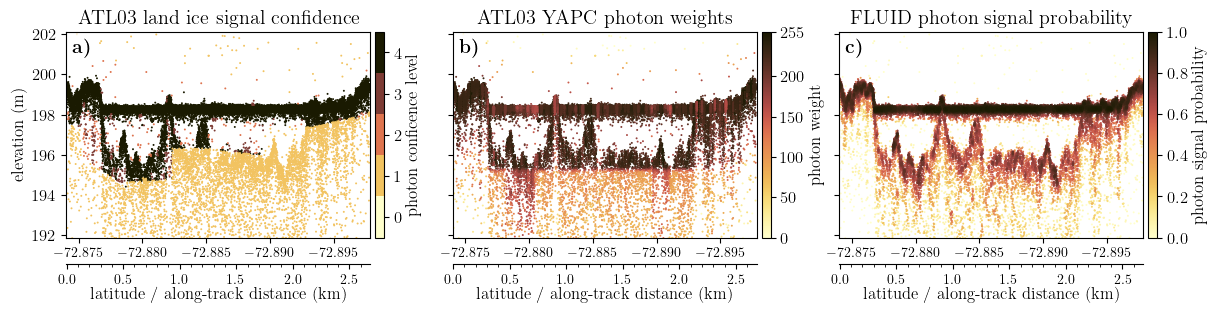

_____________________________________________________________



In [35]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
cmap_fig = cmc.lajolla

files = ['data/lakes/lake_09915520_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0062.h5']

start = 0
# end = 1
# files = np.array(df_stats.file_name)[start:end]

# files = np.array(df_stats.file_name)[[1]]

scattersize = 2
for i, fn in enumerate(files):

    print(start+i, fn[fn.find('data/lakes/lake_'):], '\n')
    
    # read in the melt lake data
    lk = dictobj(read_melt_lake_h5(fn))
    print(lk.lat, lk.lon)
    print(lk.time_utc)
    print(lk.granule_id)
    print(lk.rgt)
    print(lk.gtx)
    
    df = lk.photon_data
    df_mframe = lk.mframe_data
    xatcmin = df.xatc.min()
    df.xatc -= xatcmin
    surf_elev = lk.surface_elevation
    latmin = df.lat.min()
    latmax = df.lat.max()
    lonmin = df.lon.min()
    lonmax = df.lon.max()
    thisdate = lk.time_utc[:10]
    rgt = lk.rgt
    gtx = lk.gtx

    df = df.sort_values(by='xatc').reset_index(drop=True)
    # df2 = get_signal(df, n_iter=100, h_thresh=[200,3], xatc_win=[50,10])
    df.is_afterpulse = df.prob_afterpulse > np.random.uniform(0,1,len(df))
    df2 = df[~df.is_afterpulse].copy()
    df2 = get_density(df2[~df2.is_afterpulse], segment_length=100, signal_width=0.3, aspect=30, K_phot=15, h_signal=surf_elev, frac_noise=0.05)
    #df['density'] = df2.density
    df['density'] = 0
    df.loc[~df.is_afterpulse,'density'] = np.array(df2.density)
    # df = df2.copy()

    # download ATL03 data from NSIDC
    atl03_dir = 'data/atl03_raw'
    fn_atl03 = atl03_dir + '/' + fn[fn.find('ATL03_'):]
    if not os.path.isfile(fn_atl03):
        bbox = [lonmin, latmin, lonmax, latmax]
        granule_list = download_is2(start_date=thisdate, end_date=thisdate, rgt=rgt, boundbox=bbox, output_dir='data/atl03_raw')
        for gran in granule_list:
            if lk.granule_id[:30] in gran:
                thisfile = atl03_dir + '/processed_' + gran
                break
        os.rename(thisfile, fn_atl03)

    # read in ATL03 data from NSIDC
    beams_available, ancillary, dfs = read_atl03(fn_atl03, geoid_h=True, gtxs_to_read=gtx)
    df03 = dfs[gtx]

    #ylms = np.array((-2*lk.max_depth, 0.7*lk.max_depth)) + surf_elev
    ylms = np.array((-2.5*lk.max_depth, 1.5*lk.max_depth)) + surf_elev
    xlms = (df.lat.min(), df.lat.max())

    fig, axs = plt.subplots(figsize=[12, 3], dpi=100, nrows=1, ncols=3, sharey=True)
    ax = axs[0]
    df_conf = df03.sort_values(by='conf', ascending=False)
    n_bins = 5
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(df_conf.lat, df_conf.h, s=scattersize, alpha=1, c=df_conf.conf, cmap=thecmap, vmin=-0.5, vmax=4.5, edgecolors='none')
    ax.set_title('ATL03 land ice signal confidence')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('photon conficence level', labelpad=3)
    ax.set_ylabel('elevation (m)')

    ax = axs[1]
    df_yapc = df03.sort_values(by='weight_ph', ascending=False)
    n_bins = 255
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    scatt = ax.scatter(df_yapc.lat, df_yapc.h, s=scattersize, alpha=1, c=df_yapc.weight_ph, cmap=thecmap, vmin=0, vmax=255, edgecolors='none')
    ax.set_title('ATL03 YAPC photon weights')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical', ticks=[0, 50, 100, 150, 200, 255])
    cbar.set_label('photon weight', labelpad=3)

    # ax = axs[2]
    # df_snr = df.sort_values(by='snr')
    # n_bins = 1000
    # colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    # thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    # scatt = ax.scatter(df_snr.lat, df_snr.h, s=1, alpha=1, c=df_snr.snr/df_snr.snr.max(), cmap=thecmap, vmin=0, vmax=1)
    # ax.set_title('FLUID photon signal probability (this method)')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='4%', pad=0.05)
    # cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    # cbar.set_label('photon signal probability')

    ax = axs[2]
    dfp = df.sort_values(by='density')
    dfp = dfp[~dfp.is_afterpulse]
    n_bins = 1000
    colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
    thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
    dfp.density /= dfp.density.max()
    scatt = ax.scatter(dfp.lat, dfp.h, s=scattersize, alpha=1, c=dfp.density, cmap=thecmap, vmin=0, vmax=1, edgecolors='none')
    ax.set_title('FLUID photon signal probability')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.05)
    cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
    cbar.set_label('photon signal probability', labelpad=3)
    
    for ax in axs.flatten():
        ax.set_xlim(xlms)
        ax.set_ylim(ylms)
        ax.ticklabel_format(useOffset=False, style='plain')
        ax.tick_params(axis='x', labelsize=10)

    df['x10'] = np.round(df.xatc, -1)
    gt = df.groupby(by='x10')[['lat', 'lon']].median().sort_values(by='x10').reset_index()

    # flip x-axis if track is descending, to make along-track distance go from left to right
    if gt.lat.iloc[0] > gt.lat.iloc[-1]:
        for axx in axs.flatten():
            axx.set_xlim(np.flip(np.array(xlms)))

    # add along-track distance
    lx = gt.sort_values(by='x10').iloc[[0,-1]][['x10','lat']].reset_index(drop=True)
    _lat = np.array(lx.lat)
    _xatc = np.array(lx.x10) / 1e3
    def lat2xatc(l):
        return _xatc[0] + (l - _lat[0]) * (_xatc[1] - _xatc[0]) /(_lat[1] - _lat[0])
    def xatc2lat(x):
        return _lat[0] + (x - _xatc[0]) * (_lat[1] - _lat[0]) / (_xatc[1] - _xatc[0])

    for ax in axs.flatten():
        secax = ax.secondary_xaxis(-0.13, functions=(lat2xatc, xatc2lat))
        secax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
        secax.set_xlabel('latitude / along-track distance (km)',labelpad=0)
        secax.tick_params(axis='both', which='major', labelsize=10)
        secax.ticklabel_format(useOffset=False, style='plain')
        
    for j, ax in enumerate(axs.flatten()):
        ax.text(0.02, 0.97, r'\textbf{%s)}' % chr(ord('a') + j), transform=ax.transAxes, ha='left', va='top', fontsize=14,
               bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=.2,rounding_size=0.5', lw=0))
    
    fig.tight_layout(pad=0.1, h_pad=0.3)
    plt.savefig('plots/density_comparison.jpg', dpi=600)
    
    plt.close(fig)
    display(fig)

    print('_____________________________________________________________\n')


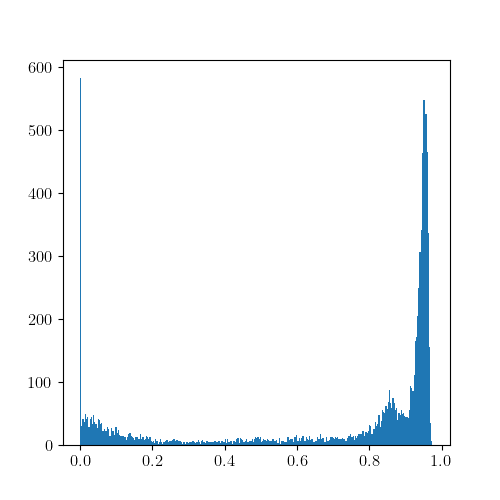

In [290]:
fig, ax = plt.subplots(figsize=[5,5], dpi=100)
ax.hist(dfp.density, bins=300);

In [236]:
plt.close('all')

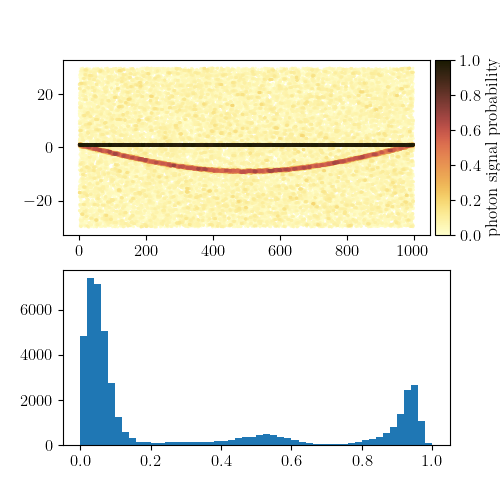

In [306]:
surf_elev = 1.0
nb = 30000
ns = 10000
frac_bed = 1 / 2
nw = int(ns * frac_bed)
xl = [0, 1000]
yl = [-30, 30]
xb = np.random.uniform(xl[0],xl[1],nb)
yb = np.random.uniform(yl[0],yl[1],nb)

xs = np.linspace(xl[0], xl[1], ns)
ys = np.ones(ns) * surf_elev + np.random.normal(loc=0.0, scale=0.05, size=ns)

xw = np.linspace(xl[0], xl[1], nw)
yw = - np.sin(xw / (xl[1] - xl[0]) * np.pi) * 10 + surf_elev + np.random.normal(loc=0.0, scale=0.3, size=nw)

x = np.hstack((xb, xs, xw))
y = np.hstack((yb, ys, yw))

df = pd.DataFrame({'xatc': x,'h': y}).sort_values(by='xatc')
df = get_density(df, segment_length=100, signal_width=0.3, aspect=30, K_phot=30, h_signal=surf_elev, frac_noise=0.05)

df.density /= df.density.max()

fig, axs = plt.subplots(figsize=[5,5], dpi=100, nrows=2)
ax = axs[0]
dfp = df.sort_values(by='density')
# dfp = dfp[dfp.density > 0.1]
n_bins = 1000
colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
#scatt = ax.scatter(dfp.xatc, dfp.h, s=0.1, alpha=1, c='k')
scatt = ax.scatter(dfp.xatc, dfp.h, s=1, alpha=1, c=dfp.density, cmap=thecmap, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('photon signal probability')

ax = axs[1]
ax.hist(df.density, bins=np.linspace(0,1,51));

In [307]:
np.mean(df.density)

0.2960347262667347

mean density: 0.05307


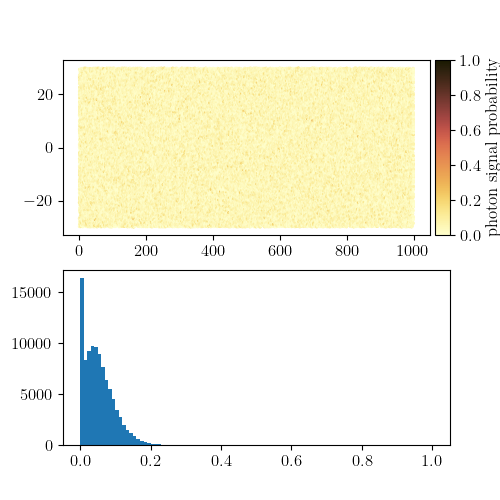

In [319]:
surf_elev = 1.0
nb = 100000
ns = 30000
frac_bed = 1 / 10
nw = int(ns * frac_bed)
xl = [0, 1000]
yl = [-30, 30]
xb = np.random.uniform(xl[0],xl[1],nb)
yb = np.random.uniform(yl[0],yl[1],nb)

df = pd.DataFrame({'xatc': xb,'h': yb}).sort_values(by='xatc')
df = get_density(df, segment_length=100, signal_width=0.3, aspect=30, K_phot=15, h_signal=surf_elev, frac_noise=0.05)

np.mean(df.density)

fig, axs = plt.subplots(figsize=[5,5], dpi=100, nrows=2)
ax = axs[0]
# dfp = df.sort_values(by='density')
dfp = df
# dfp = dfp[dfp.density > 0.1]
n_bins = 1000
colors = tuple([list(x) for x in cmap_fig(np.linspace(0,1,n_bins))])
thecmap = LinearSegmentedColormap.from_list('lajolla%s' % n_bins, colors, N=n_bins)
#scatt = ax.scatter(dfp.xatc, dfp.h, s=0.1, alpha=1, c='k')
scatt = ax.scatter(dfp.xatc, dfp.h, s=1, alpha=1, c=dfp.density, cmap=thecmap, vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='4%', pad=0.05)
cbar = fig.colorbar(scatt, cax=cax, orientation='vertical')
cbar.set_label('photon signal probability')

ax = axs[1]
ax.hist(df.density, bins=np.linspace(0,1,101));
print('mean density: %.5f' % np.mean(df.density))

0.04973759365701295